# Time Series Forecasting using Machine Learning models

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from green_city.utils import index2datetime
from green_city.regression import plot_ts, error_metrics, train_test_time_split
from green_city.regression import seasons, time_of_day, forecast_dates

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [18]:
building_nr = "all"
column_to_predict = "net_load_kWh"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building_nr": building_nr,
    "predicted_feature": column_to_predict,
    "resolution": "daily",
}

In [19]:
# Set write_date to True for logging to mlflow and SQL database
write_data = False

if write_data:
    
    # ## MLFLOW ##
    try:
        import mlflow
        from green_city.mlflow_config import get_mlflow_config

        flow_conf = get_mlflow_config()
        tracking_uri = flow_conf["TRACKING_URI"]
        mlflow.set_tracking_uri(flow_conf["TRACKING_URI"])
        mlflow.set_experiment(flow_conf["EXPERIMENT_NAME"]);
    except:
        print("mlflow ui not active")


    # ## DB CONNECTION ##
    from sqlalchemy import create_engine
    from decouple import Config, RepositoryEnv

    config = Config(RepositoryEnv("../.db_credentials"))
    db_connection_credentials = {
        "database": config('POSTGRES_DB'),
        "user": config('POSTGRES_USER'),
        "password": config('POSTGRES_PASSWORD'),
        "host": config('POSTGRES_HOST'),
        "port": config('POSTGRES_PORT'),
    }
    DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
    db = create_engine(DB_STRING)

In [20]:
# Load data
#df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df = pd.read_csv(f"../data/preprocessed/Agg_buildings.csv").astype({'datetime': 'datetime64'}).set_index('datetime')
df.fillna(0.0, inplace=True)

In [21]:
# Add additional columns for time
df['hour'] = df.index.hour.astype('category')
df['month'] = df.index.month.astype('category')
df['year'] = df.index.year.astype('category')
df['holiday'] = df['holiday'].astype('category')
df['workday'] = df['workday'].astype('category')

df['season'] = df['month'].apply(seasons).astype('category')
df['time_of_day'] = df['hour'].apply(time_of_day).astype('category')
df['day_of_week'] = df.index.day_of_week.astype('category')

# Creating lag variables
for i in range(24):
    df['net_load_kW_lag'+str(i+1)] = df['net_load_kW'].shift(i+1)

# Exogenous variables for yearly, weekly and hourly seasonality
df['year_sin365'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
df['year_cos365'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
df['year_sin365_2'] = np.sin(4 * np.pi * df.index.dayofyear / 365)
df['year_cos365_2'] = np.cos(4 * np.pi * df.index.dayofyear / 365)
df['week_sin365'] = np.sin(2 * np.pi * df.index.dayofweek/7)
df['week_cos365'] = np.cos(2 * np.pi * df.index.dayofweek/7)
df['week_sin365_2'] = np.sin(4 * np.pi * df.index.dayofweek/7)
df['week_cos365_2'] = np.cos(4 * np.pi * df.index.dayofweek/7)
df['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
df['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
df['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
df['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24) 

# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

## Lasso Regression

In [22]:
# Include weather features for random forest regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = X_train.columns[X_train.dtypes == 'float64'].to_list()
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.fit_transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Create the model
model_lasso = Lasso(alpha=0.01)

# Fit on training data
model_lasso.fit(X_train_scaled, y_train)

# Predict train and test data
y_pred_train = model_lasso.predict(X_train_scaled)
y_pred_test = model_lasso.predict(X_test_scaled)
df_test['lasso'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso Regression")                                                        

----------------------------------------
Lasso Regression
----------------------------------------
R2 (train): 0.967
R2 (test) : 0.961
MAE (test): 23.347
MSE (test): 956.029
RMSE(test): 30.92


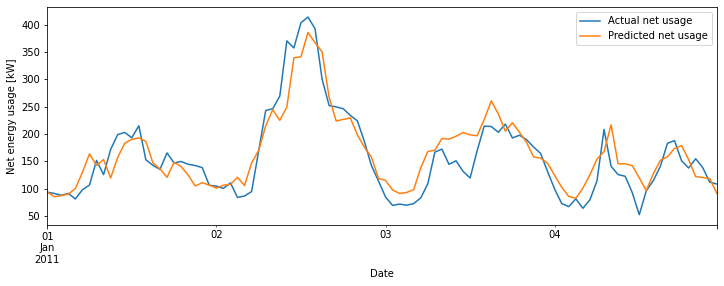

In [23]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['lasso'].iloc[0:24*4])

In [24]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"alpha": np.linspace(0.05, 0.15, 11)
             }

# Do a randomized search
lasso_gscv = GridSearchCV(
                estimator=Lasso(random_state=RSEED),
                param_grid=param_grid,
                cv=tscv, verbose=2, n_jobs=-1)

# Fit train data
model_lasso = lasso_gscv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.1s
[CV] END .........................................alpha=0.06; total time=   0.1s
[CV] END .........................................alpha=0.06; total time=   0.1s
[CV] END .........................................alpha=0.08; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.1s
[CV] END .........................................alpha=0.07; total time=   0.0s
[CV] END .........................................alpha=0.07; total time=   0.1s
[CV] END .........................................alpha=0.06; total time=   0.1s
[CV] END .........................................alpha=0.09; total time=   0.0s
[CV] END .........................................alpha=0.08; total time=   0.1s
[CV] END .......................................

In [25]:
print("Best model:", lasso_gscv.best_params_)

best_model = lasso_gscv.best_estimator_
best_params = lasso_gscv.best_params_

y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)

df_train['lasso'] = y_pred_train
df_test['lasso'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso regression")

Best model: {'alpha': 0.08}
----------------------------------------
Lasso regression
----------------------------------------
R2 (train): 0.966
R2 (test) : 0.961
MAE (test): 23.257
MSE (test): 952.308
RMSE(test): 30.859


In [26]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Scaling features
scaled_features = X_train.columns[X_train.dtypes == 'float64'].to_list()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[scaled_features] = scaler.transform(X_train_scaled[scaled_features])
X_test_scaled[scaled_features] = scaler.transform(X_test_scaled[scaled_features])

# Predict train and test data
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)
df_test['lasso'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Lasso Regression")                                                               

----------------------------------------
Lasso Regression
----------------------------------------
R2 (train): 0.966
R2 (test) : 0.961
MAE (test): 23.288
MSE (test): 956.007
RMSE(test): 30.919


Day: 2011-09-01 23:00:00, mae: 19.103, mse: 1039.434, rmse: 32.240, r2: 0.949
Day: 2011-10-20 23:00:00, mae: 20.113, mse: 851.069, rmse: 29.173, r2: 0.945
Day: 2011-01-09 06:00:00, mae: 28.091, mse: 1194.495, rmse: 34.561, r2: 0.376
Day: 2011-10-22 21:00:00, mae: 17.721, mse: 472.756, rmse: 21.743, r2: 0.834
Day: 2011-06-21 03:00:00, mae: 27.259, mse: 1236.632, rmse: 35.166, r2: 0.946
Day: 2011-07-08 02:00:00, mae: 21.816, mse: 851.761, rmse: 29.185, r2: 0.961
Day: 2011-08-19 00:00:00, mae: 31.366, mse: 2632.667, rmse: 51.310, r2: 0.938
Day: 2011-04-15 07:00:00, mae: 22.908, mse: 797.323, rmse: 28.237, r2: 0.866
Avg mae: 23.547, Avg mse: 1134.517, Avg rmse: 33.683, Avg r2: 0.866


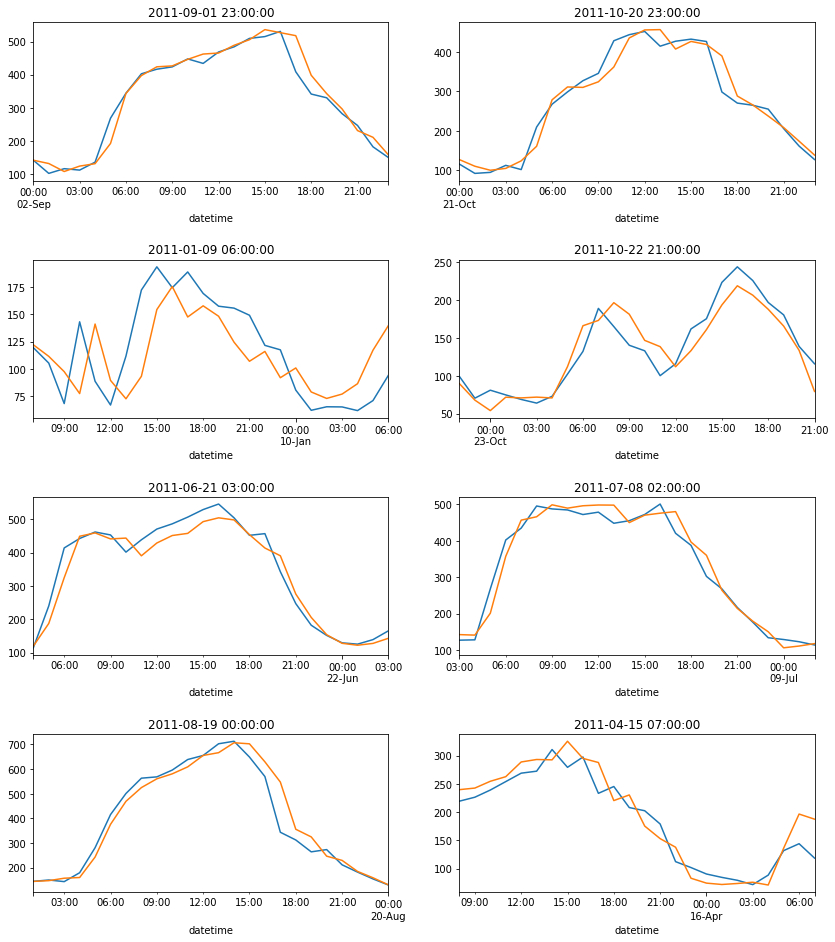

In [27]:
forecast_dates(df_test, "lasso", write_data=False)

## Random forest regression

We first train the model based on the measured weather data. We then use the trained model to forecast the net energy usage based on the 24h predicted weather data.

### Random forest regression with 1h and 24h lagged values and Fourier terms for daily, weekly and yearly seasonality

In [28]:
# Include weather features for random forest regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Create the model
rf = RandomForestRegressor(random_state=RSEED)

# Fit on training data
rf.fit(X_train, y_train)

# Predict train and test data
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
df_test['y_pred_test'] = y_pred_test

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")                                                        

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.998
R2 (test) : 0.976
MAE (test): 16.825
MSE (test): 588.063
RMSE(test): 24.25


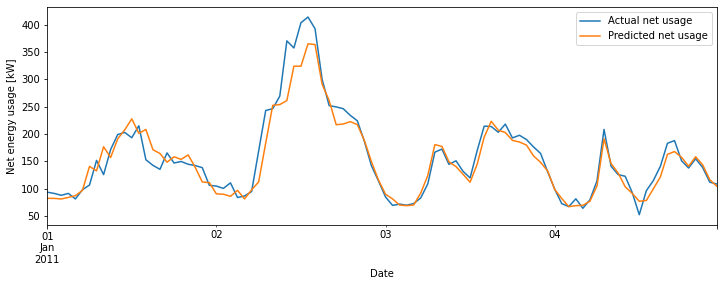

In [29]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['y_pred_test'].iloc[0:24*4])

### Run random search with cross validation to narrow down optimal hyperparameters

In [30]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"min_samples_split": [5, 6, 7, 8, 10],
                "min_samples_leaf": [5, 10, 20, 50, 80, 100],
                "max_depth": [5, 6, 7, 8],
                "n_estimators": [100, 150, 200, 250, 300]
            }

# Do a randomized search
rscv = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=RSEED),
                param_distributions=param_grid,
                cv=tscv, n_iter=20, verbose=2, n_jobs=-1)

# Fit train data
rf_search = rscv.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   3.2s
[CV] END max_depth=7, min_samples_leaf=20, min_samples_split=6, n_estimators=150; total time=   4.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=7, n_estimators=300; total time=   6.0s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   6.3s
[CV] END max_depth=7, min_samples_leaf=20, min_samples_split=6, n_estimators=150; total time=   8.5s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=150; total time=   9.5s
[CV] END max_depth=8, min_samples_leaf=20, min_samples_split=6, n_estimators=200; total time=   5.6s
[CV] END max_depth=5, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=50, min_samples_split=7, n_estimators=300; total time=  12.4s
[CV] END max_depth=5, min_samples_

In [31]:
print("Best model:", rf_search.best_params_)

rf_model = rf_search.best_estimator_
rf_params = rf_search.best_params_

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

Best model: {'n_estimators': 100, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_depth': 8}
----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.984
R2 (test) : 0.974
MAE (test): 18.177
MSE (test): 633.484
RMSE(test): 25.169


### Grid search to find the optimal hyperparameters

In [32]:
tscv = TimeSeriesSplit(n_splits=3)

estimator = RandomForestRegressor(random_state=RSEED)

param_grid = {"min_samples_split": [6, 7, 8],
                "min_samples_leaf": [10, 20, 30],
                "max_depth": [7, 8, 9],
                "n_estimators": [100, 150, 200]
            }

gsc = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=6, n_estimators=100; total time=   2.9s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=6, n_estimators=150; total time=   4.5s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=6, n_estimators=100; total time=   6.1s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=6, n_estimators=200; total time=   6.2s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=100; total time=   3.0s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=6, n_estimators=150; total time=   9.4s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=6, n_estimators=100; total time=   9.6s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=7, n_estimators=150; total time=   5.0s
[CV] END max_depth=7, min_samples_leaf=10, min_samples_split=6, n_estimators=200; total time=  12.6s
[CV] END max_depth=7, min_sam

In [33]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

{'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 6, 'n_estimators': 150}
----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.987
R2 (test) : 0.976
MAE (test): 17.546
MSE (test): 592.384
RMSE(test): 24.339


In [34]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Predict 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")                                                                                                                

Day: 2011-09-01 23:00:00, mae: 18.702, mse: 625.487, rmse: 25.010, r2: 0.969
Day: 2011-10-20 23:00:00, mae: 18.242, mse: 824.070, rmse: 28.707, r2: 0.947
Day: 2011-01-09 06:00:00, mae: 19.033, mse: 757.648, rmse: 27.525, r2: 0.604
Day: 2011-10-22 21:00:00, mae: 13.304, mse: 297.670, rmse: 17.253, r2: 0.896
Day: 2011-06-21 03:00:00, mae: 20.231, mse: 740.950, rmse: 27.220, r2: 0.967
Day: 2011-07-08 02:00:00, mae: 19.422, mse: 673.833, rmse: 25.958, r2: 0.969
Day: 2011-08-19 00:00:00, mae: 20.113, mse: 1487.002, rmse: 38.562, r2: 0.965
Day: 2011-04-15 07:00:00, mae: 20.274, mse: 690.616, rmse: 26.280, r2: 0.884
Avg mae: 18.665, Avg mse: 762.160, Avg rmse: 27.607, Avg r2: 0.884


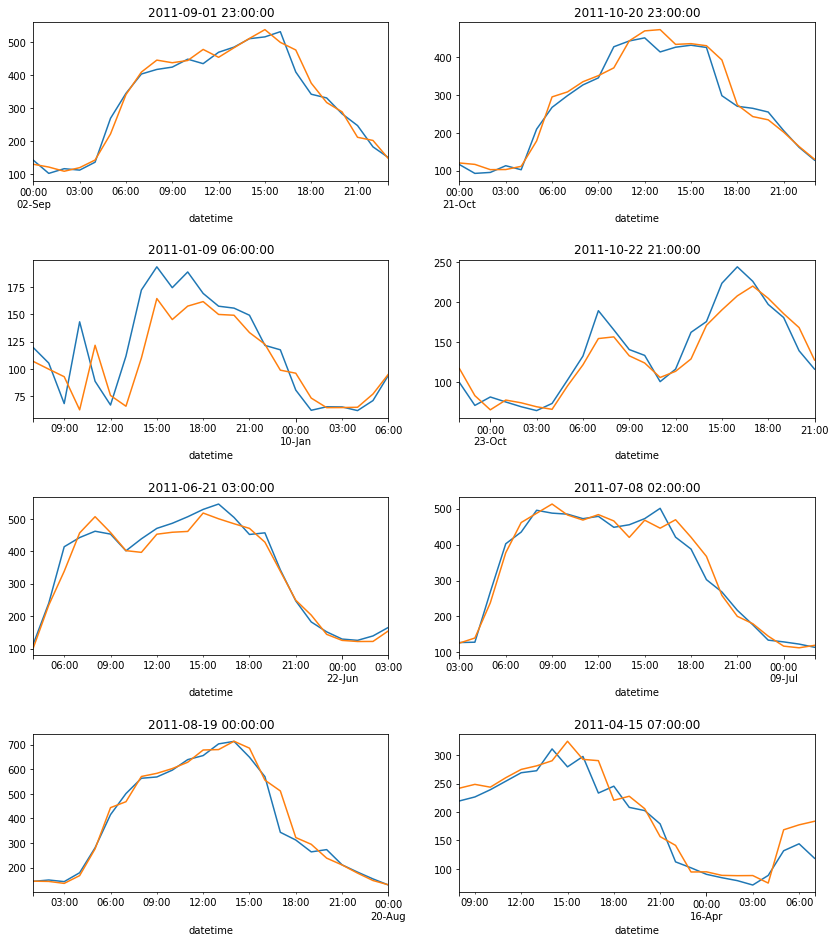

In [36]:
forecast_dates(df_test, "random_forest", write_data=False)

## XGBoost

### XGBoost including weather

In [37]:
# Include weather features 
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

# Fit training data
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=RSEED)
xg_reg.fit(X_train, y_train)  

# Predict on train and test data
y_pred_train = xg_reg.predict(X_train)
y_pred_test = xg_reg.predict(X_test)
df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.995
R2 (test) : 0.965
MAE (test): 18.526
MSE (test): 841.264
RMSE(test): 29.005


In [ ]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {"min_samples_split": [5, 6, 7, 8, 10],
                "min_samples_leaf": [5, 10, 20, 50, 80, 100],
                "max_depth": [5, 6, 7, 8],
                "n_estimators": [100, 150, 200, 250, 300]
            }

# Do a randomized search
rscv = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=RSEED),
                param_distributions=param_grid,
                cv=tscv, n_iter=20, verbose=2, n_jobs=-1)

# Fit train data
rf_search = rscv.fit(X_train, y_train)

In [27]:
# Grid search cross validation
gsc = GridSearchCV(
        estimator=xgb.XGBRegressor(),
        param_grid={"learning_rate": [0.01, 0.05, 0.10, 0.15],
                    "max_depth": [ 4, 5, 6, 7 ],
                    "n_estimators": [100, 150, 200],
                    },
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.9s[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   2.9s

[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   4.7s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   4.9s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   6.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   6.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   4.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_e

In [28]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Predict on train and test data
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)
df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.922
R2 (test) : 0.844
MAE (test): 3.269
MSE (test): 19.335
RMSE(test): 4.397


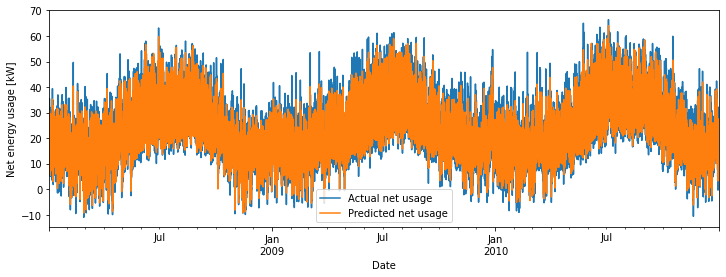

In [51]:
plot_ts(df_train['net_load_kW'], df_train['xgboost'])

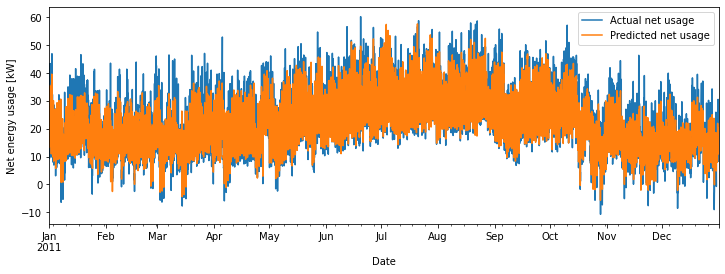

In [52]:
plot_ts(df_test['net_load_kW'], df_test['xgboost'])

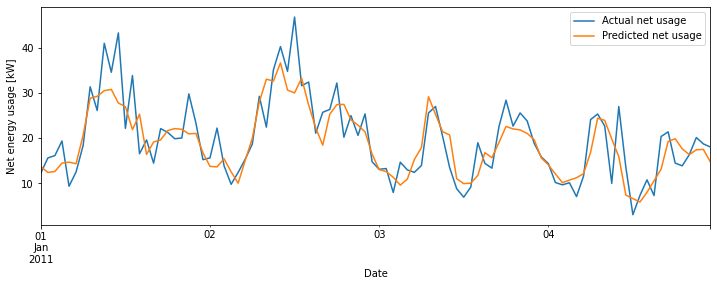

In [78]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['xgboost'].iloc[0:24*4])

### XGBoost using weather predictions

In [ ]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'time_of_day', 'season', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['time_of_day', 'season', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [30]:
# Forecast using 24h weather predictions 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.922
R2 (test) : 0.844
MAE (test): 3.269
MSE (test): 19.335
RMSE(test): 4.397
